# Vorticity & vorticity index

In [2]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts
import Atmos_tools as Ats

In [3]:
reload(Ats)

<module 'Atmos_tools' from '../../_libs/Atmos_tools.pyc'>

In [4]:
import glob
import datetime
import scipy.io
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
% matplotlib inline

In [5]:
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

# Relative vorticity calculation

Relative vorticity: The vertical component of $\mathsf{\nabla\times\vec{v}}$ and $\mathsf{\vec{v}}$ is relative to the Earth.
$$
\zeta = \frac{\Delta v}{\Delta x} - \frac{\Delta u}{\Delta y} + \frac{u}{R}tan(lat)
$$
For regular lon/lat frame:
$$
\Delta x = R\Delta lon \cdot cos(lat) \\
\Delta y = R\Delta lat
$$
If in ANHA4, maybe:
$$
\Delta x = e1t \\
\Delta y = e2t
$$

In [6]:
year = np.arange(2002, 2014)
u10 = np.empty([144, 368, 801])
v10 = np.empty([144, 368, 801])
slp = np.empty([144, 368, 801])
for i in range(12):
    name_u = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/*u*'+str(year[i])+'*monmean*')
    name_v = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/*v*'+str(year[i])+'*monmean*')
    name_slp = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/*slp*'+str(year[i])+'*monmean*')
    u_obj = nc.Dataset(name_u[0])
    v_obj = nc.Dataset(name_v[0])
    slp_obj = nc.Dataset(name_slp[0])
    u10[i*12:(i+1)*12, :, :] = u_obj.variables['u_wind'][:, :, :]
    v10[i*12:(i+1)*12, :, :] = v_obj.variables['v_wind'][:, :, :]
    slp[i*12:(i+1)*12, :, :] = slp_obj.variables['atmpres'][:, :, :]

In [7]:
x = u_obj.variables['LON'][:]
y = u_obj.variables['LAT'][:]
[lon, lat] = np.meshgrid(x, y)

In [8]:
#u10 = np.transpose(u10, [1, 2, 0])
#v10 = np.transpose(v10, [1, 2, 0])
u10_np = u10[:, y>20, :]
v10_np = v10[:, y>20, :]
slp_np = slp[:, y>20, :]
lon_np = lon[y>20, :]
lat_np = lat[y>20, :]
u10_np_mean = np.mean(u10_np, 0)
v10_np_mean = np.mean(v10_np, 0)
slp_np_mean = np.mean(slp_np, 0)

In [9]:
def plot_curl(lon, lat, u, v, lev, ax):
    curlz = Ats.curlz_atmos(lon, lat, u, v)
    proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.drawcoastlines(linewidth=1.5, color='k')
    x, y=proj(lon, lat)
    #uproj, vproj, xx, yy = proj.rotate_vector(u, v, lon, lat, returnxy=True)
    CS=proj.contourf(x, y, curlz*1e5, lev, cmap=plt.cm.RdBu_r, extend='both')
    #proj.quiver(xx[::5, ::5], yy[::5, ::5], uproj[::5, ::5], vproj[::5, ::5], scale=200)
    return CS

In [10]:
curlz_mean = Ats.curlz_atmos(lon_np, lat_np, u10_np_mean, v10_np_mean)

In [11]:
lev_curl = np.array([-2.25, -1.75, -1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, 2.25])*1.5

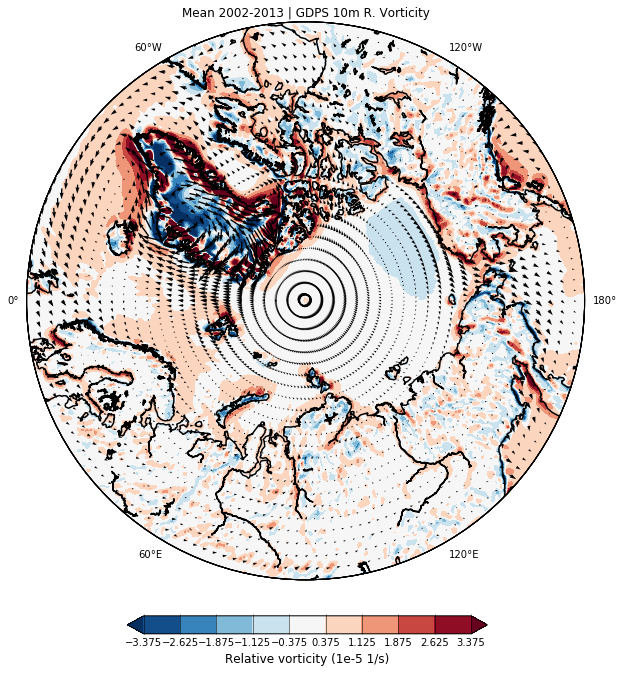

In [12]:
fig=plt.figure(figsize=(10, 10));
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
#proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y=proj(lon_np, lat_np)
uproj, vproj, xx, yy = proj.rotate_vector(u10_np_mean, v10_np_mean, lon_np, lat_np, returnxy=True)
CS=proj.contourf(x, y, curlz_mean*1e5, lev_curl, cmap=plt.cm.RdBu_r, extend='both')
proj.quiver(xx[::5, ::5], yy[::5, ::5], uproj[::5, ::5], vproj[::5, ::5], scale=200)

ax.set_title('Mean 2002-2013 | GDPS 10m R. Vorticity', fontsize=12)

cax = fig.add_axes([0.265, 0.05, 0.5, 0.025])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Relative vorticity (1e-5 1/s)', fontsize=12)
CBar.ax.tick_params(axis='x', length=20)
CBar.set_ticks(lev_curl)

In [13]:
#for i in range(144):
#    print(i)
#    fig = plt.figure(figsize=(10, 10))
#    ax = fig.gca()
#    ax.set_title(date_list[i].strftime("%Y-%m-%d"), fontsize=16)
#    CS = plot_curl(lon_np, lat_np, u10_np[i, :, :], v10_np[i, :, :], lev_curl, ax)
    
#    cax = fig.add_axes([0.265, 0.05, 0.5, 0.025])
#    CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
#    CBar.set_label('Relative vorticity (1e-5 1/s)', fontsize=12)
#    CBar.ax.tick_params(axis='x', length=20)
#    CBar.set_ticks(lev_curl)
    
#    fig.savefig('Zeta_'+str(i)+'.png', dpi=200, orientation='portrait', papertype='a4', format='png',
#                bbox_inches='tight', pad_inches=0.1)

# (X) Vorticity index

In [24]:
lon_circ, lat_circ = Ats.equi(125, 82, 550)

In [25]:
import matplotlib.path as Path
bbPath = Path.Path(np.vstack([lon_circ, lat_circ]).T)
inside = np.zeros([233, 801])
for i in range(233):
    for j in range(801):
        inside[i, j] = bbPath.contains_point((lon_np[i, j], lat_np[i, j]))

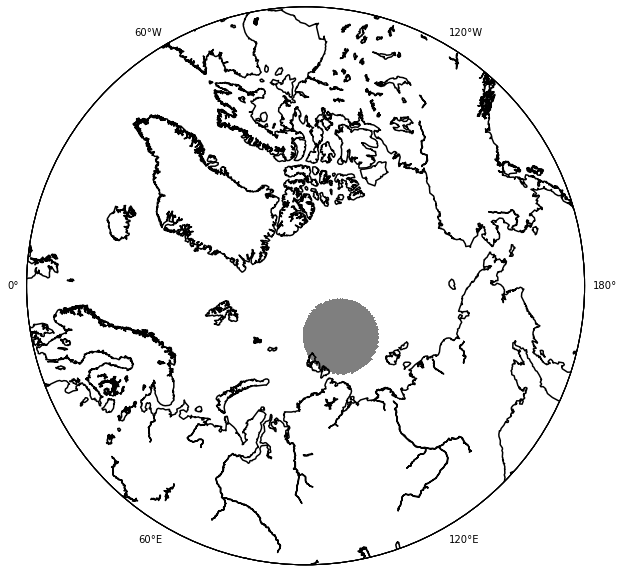

In [26]:
fig=plt.figure(figsize=(10, 10));
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
#proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y = proj(lon_np, lat_np)
proj.pcolor(x, y, inside, vmax=2, cmap=plt.cm.gray_r)

In [27]:
#curlz = np.zeros([144, 233, 801])
vor_ind = np.zeros([144])

for i in range(144):
    temp = Ats.curlz_atmos(lon_np, lat_np, u10_np[i, :, :], v10_np[i, :, :])
    vor_ind[i] = np.mean(temp[inside==1])


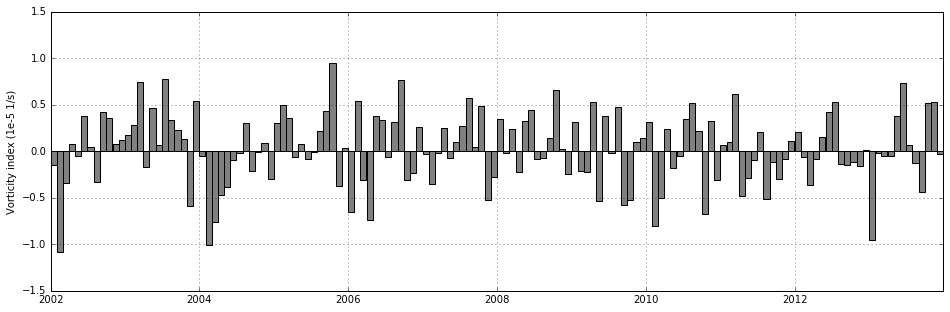

In [28]:
fig = plt.figure(figsize=(16, 5))
ax = fig.gca(); ax.grid()
#
ax.bar(date_list, vor_ind*1e5, width=30, color='gray', lw=1)
ax.axhline(y=0, xmin=0, xmax=1, color='k')
ax.set_ylim([-1.5, 1.5])
ax.set_ylabel('Vorticity index (1e-5 1/s)')

In [29]:
#vor_ind = AO_index[0, :]

u10_pv = np.mean(u10_np[vor_ind>0, :, :], 0)
v10_pv = np.mean(v10_np[vor_ind>0, :, :], 0)
slp_pv = np.mean(slp_np[vor_ind>0, :, :], 0)/100

u10_nv = np.mean(u10_np[vor_ind<0, :, :], 0)
v10_nv = np.mean(v10_np[vor_ind<0, :, :], 0)
slp_nv = np.mean(slp_np[vor_ind<0, :, :], 0)/100

In [30]:
name = glob.glob('../../_data/NEMO/INPUT_DYNA/*')
NC = nc.Dataset(name[0])
nav_lat = NC.variables['nav_lat'][:]
nav_lon = NC.variables['nav_lon'][:]

In [31]:
nav_lon[nav_lon<0]=nav_lon[nav_lon<0]+360
#Class_interp = reporj_NEMOgrid(lon, lat, Class, ANHA4_lon, ANHA4_lat, method='nearest')
u10_pv_orca = Nts.reporj_NEMOgrid(lon_np, lat_np, u10_pv, nav_lon, nav_lat, method='linear')
v10_pv_orca = Nts.reporj_NEMOgrid(lon_np, lat_np, v10_pv, nav_lon, nav_lat, method='linear')
u10_nv_orca = Nts.reporj_NEMOgrid(lon_np, lat_np, u10_nv, nav_lon, nav_lat, method='linear')
v10_nv_orca = Nts.reporj_NEMOgrid(lon_np, lat_np, v10_nv, nav_lon, nav_lat, method='linear')

/home/yingkai/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3109: RuntimeWarning: invalid value encountered in greater_equal
  farnorth = np.abs(lats+dlat) >= 90.0


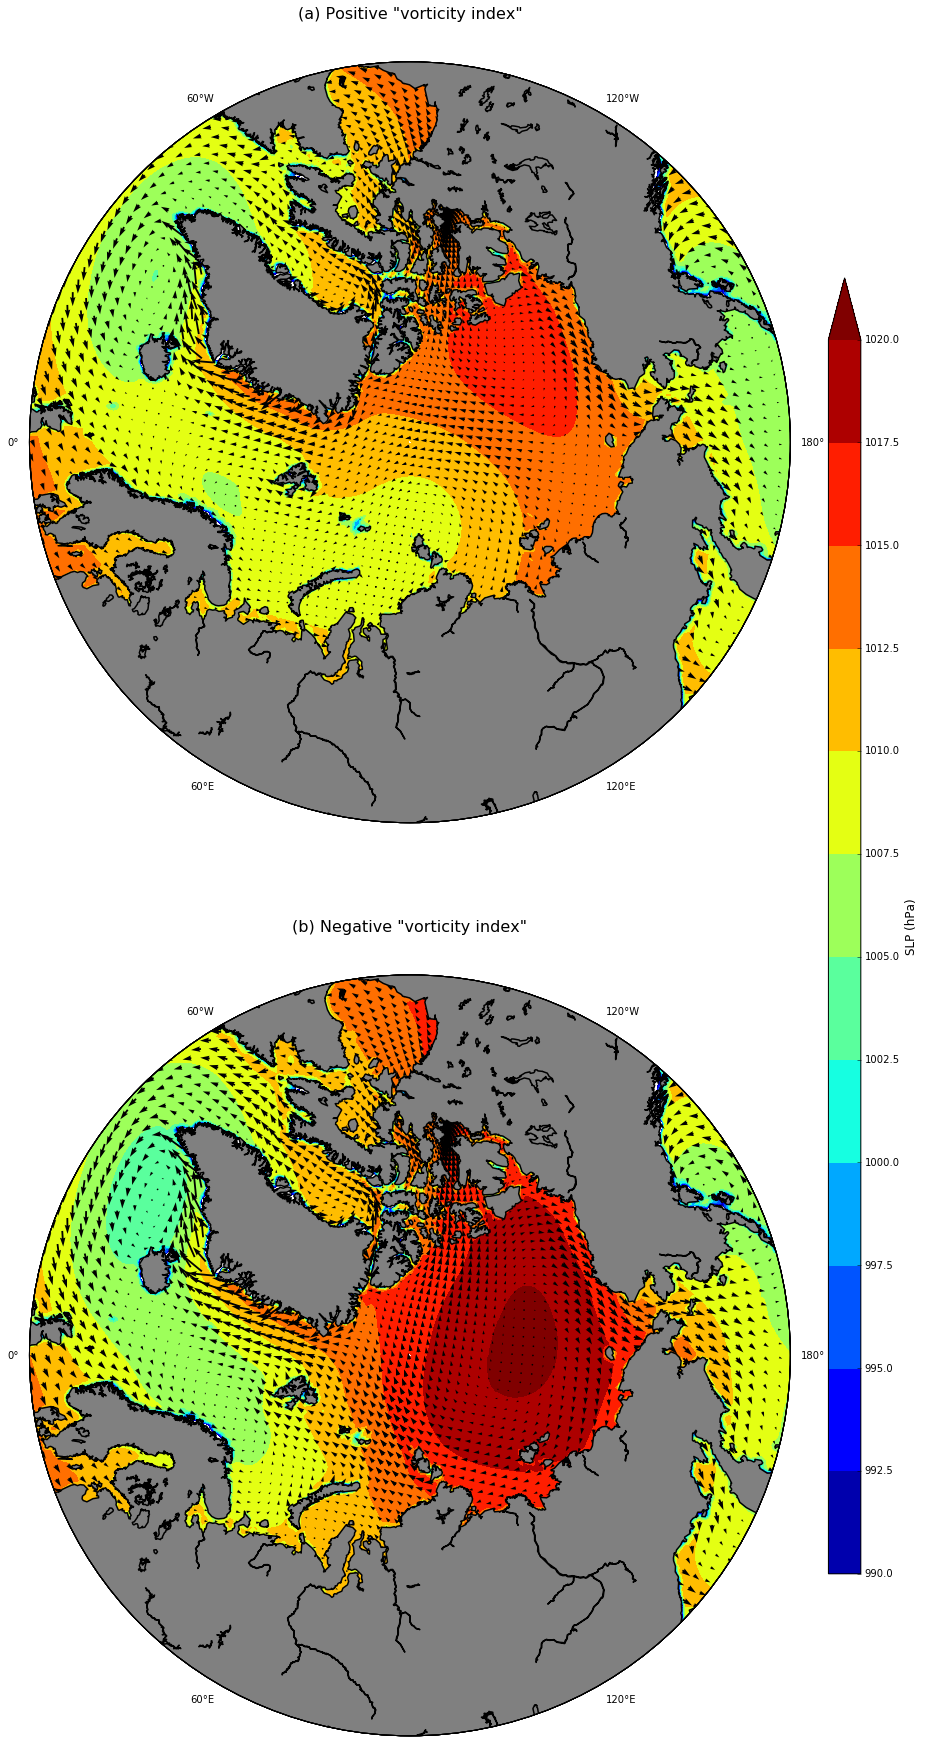

In [32]:
lev_slp = np.arange(990, 1022.5, 2.5)

fig=plt.figure(figsize=(15, 30));

ax1 = plt.subplot2grid((2, 1), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((2, 1), (1, 0), colspan=1, rowspan=1)
#ax = fig.gca()

proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax1)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y=proj(lon_np, lat_np)
CS=proj.contourf(x, y, slp_pv, lev_slp, cmap=plt.cm.jet, extend='max')
uproj, vproj, xx, yy = proj.rotate_vector(u10_pv_orca, v10_pv_orca, nav_lon, nav_lat, returnxy=True)
proj.quiver(xx[::1, ::1], yy[::1, ::1], uproj[::1, ::1], vproj[::1, ::1], scale=200)
ax1.set_title('(a) Positive "vorticity index"', y=1.05, fontsize=16)


proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax2)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y=proj(lon_np, lat_np)
CS=proj.contourf(x, y, slp_nv, lev_slp, cmap=plt.cm.jet, extend='max')
uproj, vproj, xx, yy = proj.rotate_vector(u10_nv_orca, v10_nv_orca, nav_lon, nav_lat, returnxy=True)
proj.quiver(xx[::1, ::1], yy[::1, ::1], uproj[::1, ::1], vproj[::1, ::1], scale=200)
ax2.set_title('(b) Negative "vorticity index"', y=1.05, fontsize=16)

cax = fig.add_axes([0.9, 0.2, 0.03, 0.6])
CBar = fig.colorbar(CS, cax=cax, orientation='vertical')
CBar.set_label('SLP (hPa)', fontsize=12)
CBar.ax.tick_params(axis='x', length=16)
CBar.set_ticks(lev_slp)

#fig.savefig('_publish/FIG11.pdf', dpi=600, orientation='portrait', papertype='a4', format='pdf',
#                bbox_inches='tight', pad_inches=0.1)

In [40]:
save_var = {'vor':vor_ind}
scipy.io.savemat('../../_data/Exchange/vor_index.mat', mdict=save_var)

In [33]:
MAT = scipy.io.loadmat('../../_data/Exchange/AO_inds.mat')
AO_index = MAT['AO_index']

In [34]:
from scipy.stats.stats import pearsonr

# AO index

In [35]:
ao_ind = AO_index[0, :]

u10_pa = np.mean(u10_np[ao_ind>0, :, :], 0)
v10_pa = np.mean(v10_np[ao_ind>0, :, :], 0)
slp_pa = np.mean(slp_np[ao_ind>0, :, :], 0)/100

u10_na = np.mean(u10_np[ao_ind<0, :, :], 0)
v10_na = np.mean(v10_np[ao_ind<0, :, :], 0)
slp_na = np.mean(slp_np[ao_ind<0, :, :], 0)/100

u10_pa_orca = Nts.reporj_NEMOgrid(lon_np, lat_np, u10_pa, nav_lon, nav_lat, method='linear')
v10_pa_orca = Nts.reporj_NEMOgrid(lon_np, lat_np, v10_pa, nav_lon, nav_lat, method='linear')
u10_na_orca = Nts.reporj_NEMOgrid(lon_np, lat_np, u10_na, nav_lon, nav_lat, method='linear')
v10_na_orca = Nts.reporj_NEMOgrid(lon_np, lat_np, v10_na, nav_lon, nav_lat, method='linear')


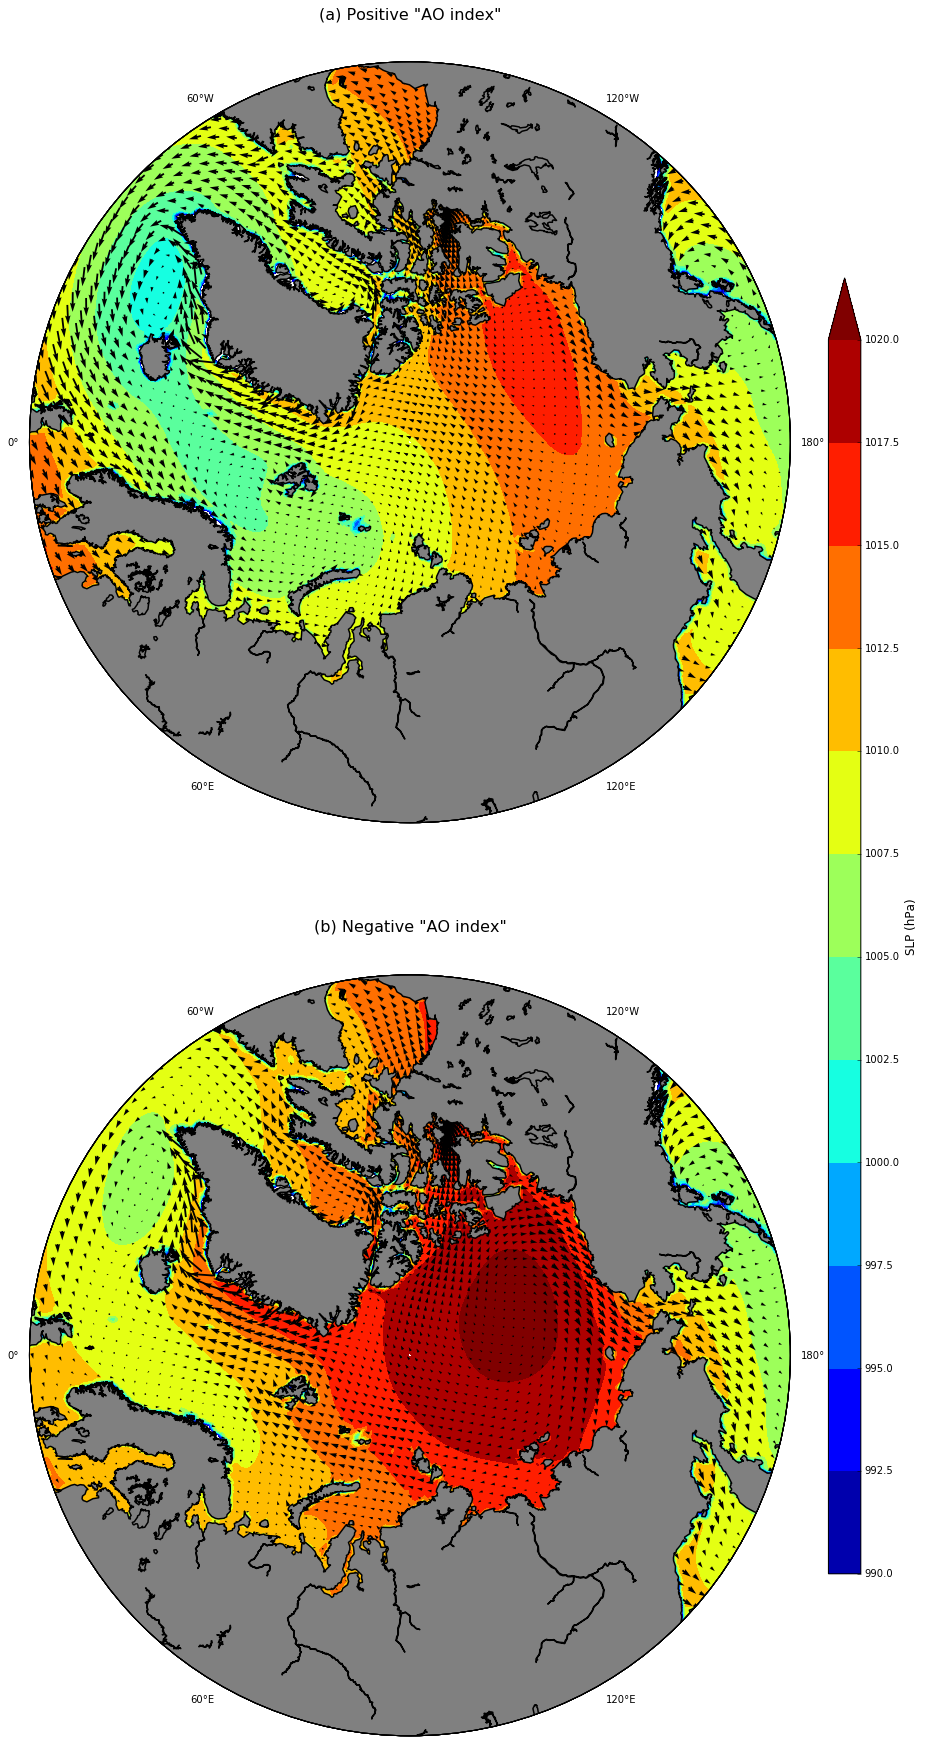

In [38]:
fig=plt.figure(figsize=(15, 30));

ax1 = plt.subplot2grid((2, 1), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((2, 1), (1, 0), colspan=1, rowspan=1)
#ax = fig.gca()

proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax1)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y=proj(lon_np, lat_np)
CS=proj.contourf(x, y, slp_pa, lev_slp, cmap=plt.cm.jet, extend='max')
uproj, vproj, xx, yy = proj.rotate_vector(u10_pa_orca, v10_pa_orca, nav_lon, nav_lat, returnxy=True)
proj.quiver(xx[::1, ::1], yy[::1, ::1], uproj[::1, ::1], vproj[::1, ::1], scale=200)
ax1.set_title('(a) Positive "AO index"', y=1.05, fontsize=16)


proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax2)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y=proj(lon_np, lat_np)
CS=proj.contourf(x, y, slp_na, lev_slp, cmap=plt.cm.jet, extend='max')
uproj, vproj, xx, yy = proj.rotate_vector(u10_na_orca, v10_na_orca, nav_lon, nav_lat, returnxy=True)
proj.quiver(xx[::1, ::1], yy[::1, ::1], uproj[::1, ::1], vproj[::1, ::1], scale=200)
ax2.set_title('(b) Negative "AO index"', y=1.05, fontsize=16)

cax = fig.add_axes([0.9, 0.2, 0.03, 0.6])
CBar = fig.colorbar(CS, cax=cax, orientation='vertical')
CBar.set_label('SLP (hPa)', fontsize=12)
CBar.ax.tick_params(axis='x', length=16)
CBar.set_ticks(lev_slp)